<h1 style="text-align: center;"> Model Tuning </p>

<a id='Table-of-Contents'></a>


##  Table of Contents
1. [Required Libraries](#Required-Libraries)
2. [Load Data](#Load-Data)
3. 

## Required Libraries

[[ go back to the top ]](#Table-of-contents)

This notebook uses several Python libraries such as:

In [183]:
# Load required packages 
import datetime
from datetime import timedelta
import numpy as np
import pandas as pd
import os

# Visuals
import matplotlib.pyplot as plt
import seaborn as sns

# Time-Series
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARMA, ARIMA

from sklearn.model_selection import train_test_split  

from scipy import signal
import scipy.stats as stats

from Functions import LOAD_DATA

import warnings
warnings.filterwarnings("ignore")

<a id='Load-Data'></a>

---
## Load Data

[[ go back to the top ]](#Table-of-Contents)

In [2]:
# Load Data Function
def LOAD_DATA(filepath, filename):
    # Read CSV files
    if filename.endswith('.csv'):
        new_df = pd.read_csv(filepath+filename)

    # Read Excel files
    elif filename.endswith('.xlsx'):
        new_df = pd.read_excel(filepath+filename)
    print(type(new_df.index))
    if type(new_df.index) != pd.core.indexes.datetimes.DatetimeIndex:
        for col in new_df.columns:
            if col.lower().find('date') != -1:
                print(f"TIMESTAMP FOUND! '{col}'")
                print()
                new_df['date'] = pd.to_datetime(new_df[col]) # format = '%Y/%m/%d'
                new_df.set_index('date', inplace = True)
                # If datetime col was already == 'date', no need to drop col after set_index, otherwise...
                if col != 'date':
                    new_df.drop(columns = col, inplace = True)
                
    # Try to identify the date column
    elif type(new_df.index) == pd.core.indexes.datetimes.DatetimeIndex:
        print('Index already in datetime')
        
    display(new_df.info())
    return new_df

In [3]:
filepath = '../../'
filename = 'lagged_wmobility_df.csv'
df = LOAD_DATA(filepath, filename)

<class 'pandas.core.indexes.range.RangeIndex'>
TIMESTAMP FOUND! 'date'

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 243 entries, 2020-02-19 to 2021-02-25
Data columns (total 85 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   phillips_66                            243 non-null    float64
 1   bp_plc                                 243 non-null    float64
 2   valero_energy_corporation              243 non-null    float64
 3   chevron_corporation                    243 non-null    float64
 4   occidental_petroleum_corporation       243 non-null    float64
 5   marathon_oil_corporation               243 non-null    float64
 6   pioneer_natural_resources_company      243 non-null    float64
 7   conocophillips                         243 non-null    float64
 8   exxon_mobil_corporation                243 non-null    float64
 9   marathon_petroleum_corporation         243 non-null

None

### Fit an ARIMA Model

In [505]:
# Set-Up Target-Variables: NYSE Closing Price
targets = ['phillips_66',
           'bp_plc',
           'valero_energy_corporation',
           'chevron_corporation',
           'occidental_petroleum_corporation',
           'marathon_oil_corporation',
           'pioneer_natural_resources_company',
           'conocophillips',
           'exxon_mobil_corporation',
           'marathon_petroleum_corporation']

# DataFrame of 10 large Oil Companies
target_df = df[targets]

KeyError: "None of [Index(['phillips_66', 'bp_plc', 'valero_energy_corporation',\n       'chevron_corporation', 'occidental_petroleum_corporation',\n       'marathon_oil_corporation', 'pioneer_natural_resources_company',\n       'conocophillips', 'exxon_mobil_corporation',\n       'marathon_petroleum_corporation'],\n      dtype='object')] are in the [columns]"

### ARIMA trouble predicting with all the features

In [8]:
# # Create Train/Test-Split
# # Typical: test_size = most recent 20%(small datasets) - 33%(large datasets)
# X_train, X_valid, y_train, y_valid = train_test_split(df.drop(columns = targets),  
#                                                     df['phillips_66'],  
#                                                     test_size = 0.2, 
#                                                     shuffle = False) 

### Try fewer features

In [29]:
# Create Train/Test-Split
# Typical: test_size = most recent 20%(small datasets) - 33%(large datasets)
X_train, X_valid, y_train, y_valid = train_test_split(df['lag_phillips_66'],  
                                                    df['phillips_66'],  
                                                    test_size = 0.2, 
                                                    shuffle = False) 

In [30]:
# Check shape and verify proper split above 
print(X_train.shape) 
print(X_valid.shape)  
print(y_train.shape) 
print(y_valid.shape)

(194,)
(49,)
(194,)
(49,)


In [31]:
# Before fitting a model in statsmodels (Hint: Add the intercept)  
X_train = sm.add_constant(X_train) 
X_valid = sm.add_constant(X_valid)
# Check that all is copacetic  
X_train.head()

,const,lag_phillips_66
date,,
2020-02-19,1.0,88.00
2020-02-20,1.0,88.36
2020-02-21,1.0,90.19
2020-02-24,1.0,89.25
2020-02-25,1.0,86.56


In [32]:
# statsmodels can't handle missing values
X_train.isnull().sum().sum(), X_valid.isnull().sum().sum(), y_train.isnull().sum().sum(), y_valid.isnull().sum().sum()

(0, 0, 0, 0)

In [33]:
# Starting AIC, p, and q.
best_aic = 99 * (10 ** 16) # Just a really big number
best_p = 0
best_q = 0

# Use nested for loop to iterate over values of p and q.
for p in range(5):
    for q in range(5):
        # Insert try and except statements.
        try:
            # Fitting an ARIMA(p, 1, q) model.
            print(f'Attempting to fit ARIMA({p},1,{q})') # Default d=1 is given
            
            # Instantiate ARIMA model
            arima = ARIMA(endog = y_train.astype(float).dropna(), # endog = Y variable ,"enogenous param"
                          order = (p,1,q)) # values of p, d, q
            
            # Fit ARIMA model.
            model = arima.fit()

            # Print out AIC for ARIMA(p, 1, q) model.
            print(f'The AIC for ARIMA({p},1,{q}) is: {model.aic}')

            # Is my current model's AIC better than our best_aic?
            if model.aic < best_aic: # Update best params if new and improved score
                
                # If so, let's overwrite best_aic, best_p, and best_q.
                best_aic = model.aic
                best_p = p
                best_q = q

        except:
            pass
print()
print()
print('MODEL FINISHED!')
print(f'Our model that minimizes AIC on the training data is the ARIMA({best_p},1,{best_q}).')
print(f'This model has an AIC of {best_aic}.')

Attempting to fit ARIMA(0,1,0)
The AIC for ARIMA(0,1,0) is: 951.6998547025115
Attempting to fit ARIMA(0,1,1)
The AIC for ARIMA(0,1,1) is: 953.3031635328748
Attempting to fit ARIMA(0,1,2)
The AIC for ARIMA(0,1,2) is: 955.0060752405045
Attempting to fit ARIMA(0,1,3)
The AIC for ARIMA(0,1,3) is: 956.9022421570714
Attempting to fit ARIMA(0,1,4)
The AIC for ARIMA(0,1,4) is: 958.5193520310094
Attempting to fit ARIMA(1,1,0)
The AIC for ARIMA(1,1,0) is: 953.2722922696566
Attempting to fit ARIMA(1,1,1)
The AIC for ARIMA(1,1,1) is: 954.7027571922815
Attempting to fit ARIMA(1,1,2)
The AIC for ARIMA(1,1,2) is: 956.0083614155967
Attempting to fit ARIMA(1,1,3)
The AIC for ARIMA(1,1,3) is: 957.9833749226788
Attempting to fit ARIMA(1,1,4)
The AIC for ARIMA(1,1,4) is: 959.7859321993653
Attempting to fit ARIMA(2,1,0)
The AIC for ARIMA(2,1,0) is: 955.0106725087346
Attempting to fit ARIMA(2,1,1)
The AIC for ARIMA(2,1,1) is: 956.0492599776812
Attempting to fit ARIMA(2,1,2)
The AIC for ARIMA(2,1,2) is: 954.

In [269]:
def gap_check(dataframe, d):
    df = dataframe
    delta_df = pd.DataFrame(df.index)
    delta = [0]
    if 'Date' in delta_df.columns:
        delta_df.rename(columns={"Date": "date"}, inplace =True)
    if 'DateTime' in delta_df.columns:
        delta_df.rename(columns={"DateTime": "date"}, inplace =True)
    day_names = [delta_df.date[0].strftime('%A')]
    for dates in range(1, len(df)):
        delta.append((df.index[dates]-df.index[dates-1]).days)
        day_names.append(delta_df.date[dates].strftime('%A'))
    delta_df['day_of_week'] = day_names
    delta_df['deltas'] = delta
    return delta_df[delta_df.deltas >= d]

In [158]:
df = pd.read_csv(r'../../lagged_wmobility_df.csv',
            index_col = 0,
            parse_dates=True,
            infer_datetime_format=True,
            keep_date_col=True)
gap_check(df, 5)

,date,day_of_week,deltas
15,2020-03-16,Monday,5
20,2020-03-30,Monday,7
25,2020-04-16,Thursday,13


In [159]:
df = pd.read_csv(r'../../lagged_wout_mobility.csv',
            index_col = 0,
            parse_dates=True,
            infer_datetime_format=True,
            keep_date_col=True)
gap_check(df, 5)

,date,day_of_week,deltas
72,2017-07-05,Wednesday,5
423,2018-11-26,Monday,5
442,2018-12-26,Wednesday,5
445,2019-01-02,Wednesday,5
572,2019-07-08,Monday,5
742,2020-03-16,Monday,5
747,2020-03-30,Monday,7
752,2020-04-16,Thursday,13


In [160]:
df = pd.read_csv(r'../../target_with_all_features_clean.csv',
            index_col = 'date',
            parse_dates=True,
            infer_datetime_format=True,
            keep_date_col=True)
gap_check(df, 5)

,date,day_of_week,deltas
16,2020-03-16,Monday,5
21,2020-03-30,Monday,7
26,2020-04-16,Thursday,13


In [161]:
df = pd.read_csv(r'../../targets_wout_mobility2.csv',
            index_col = 'date',
            parse_dates=True,
            infer_datetime_format=True,
            keep_date_col=True)
gap_check(df, 5)

,date,day_of_week,deltas
752,2020-03-16,Monday,5
759,2020-03-29,Sunday,6
767,2020-04-16,Thursday,11


In [162]:
files = ['apple_mobility_top5countries.csv',
         'closing_price_by_company.csv',
         'exxon_sentiment_clean.csv',
         'model_ready_data.csv',
         'targets_with_all_features.csv',
         'targets_wout_mobility.csv',
         'Germany_avg_trans.csv']
for i in range(len(files)):
    df = pd.read_csv(r'../../modeling_csvs/'+files[i],
            index_col = 0,
            parse_dates=True,
            infer_datetime_format=True,
            keep_date_col=True)
    print()
    display(files[i].upper())
    #display(df)
    display(gap_check(df, 5))

'APPLE_MOBILITY_TOP5COUNTRIES.CSV'

,date,day_of_week,deltas


'CLOSING_PRICE_BY_COMPANY.CSV'

,date,day_of_week,deltas
752,2020-03-16,Monday,5
759,2020-03-29,Sunday,6
767,2020-04-16,Thursday,11


'EXXON_SENTIMENT_CLEAN.CSV'

,date,day_of_week,deltas
767,2020-03-16,Monday,5
774,2020-03-29,Sunday,6
782,2020-04-16,Thursday,11


'MODEL_READY_DATA.CSV'

,date,day_of_week,deltas
16,2020-03-16,Monday,5
21,2020-03-30,Monday,7
26,2020-04-16,Thursday,13


'TARGETS_WITH_ALL_FEATURES.CSV'

,date,day_of_week,deltas
16,2020-03-16,Monday,5
21,2020-03-30,Monday,7
26,2020-04-16,Thursday,13


'TARGETS_WOUT_MOBILITY.CSV'

,date,day_of_week,deltas
752,2020-03-16,Monday,5
759,2020-03-29,Sunday,6
767,2020-04-16,Thursday,11


'GERMANY_AVG_TRANS.CSV'

,date,day_of_week,deltas


In [163]:
files = ['nyse_closing_new3.16.21.xlsx']
for i in range(len(files)):
    df = pd.read_excel(r'../../data/'+files[i],
            index_col = 'Date',
            parse_dates=True,
            infer_datetime_format=True,
            keep_date_col=True)
    df.sort_index(inplace = True)
    print()
    display(files[i].upper())
    #display(df)
    display(gap_check(df, 0))

'NYSE_CLOSING_NEW3.16.21.XLSX'

,date,day_of_week,deltas
0,2017-03-08,Wednesday,0
1,2017-03-09,Thursday,1
2,2017-03-09,Thursday,0
3,2017-03-09,Thursday,0
4,2017-03-09,Thursday,0
...,...,...,...
9995,2021-03-05,Friday,0
9996,2021-03-05,Friday,0
9997,2021-03-05,Friday,0
9998,2021-03-05,Friday,0


In [319]:
folder = 'sentiment_new/direct_financial'
directory = '../../data/'+folder+'/'
    
for filename in os.listdir(directory):
    if filename[-4:] == '.csv':
        filepath = os.path.join(directory, filename)
        # Read CSV files
        df = pd.read_csv(filepath,
                         index_col = 'DateTime',
                         parse_dates=True,
                         infer_datetime_format=True,
                         keep_date_col=True)
        df = df[df.index >= '2020-03-01']
        df.sort_index(inplace = True)
        print()
        display(filename[:-4].upper())
        display(f'Days in Range: {len(df)}')
        display(f'Null Values: {df.Index.isnull().sum()}')
        display(df)
        #display(df)
        display(gap_check(df, 3))

'D_F_CHEVRON'

'Days in Range: 382'

'Null Values: 285'

,Index,Count
DateTime,,
2020-03-01,NaN,0
2020-03-02,0.00,2
2020-03-03,NaN,1
2020-03-04,-0.20,2
2020-03-05,NaN,0
...,...,...
2021-03-13,NaN,0
2021-03-14,NaN,0
2021-03-15,NaN,0


,date,day_of_week,deltas


'D_F_DRILLING'

'Days in Range: 383'

'Null Values: 169'

,Index,Count
DateTime,,
2020-03-01,NaN,0
2020-03-02,-0.100000,1
2020-03-03,0.033333,3
2020-03-04,NaN,0
2020-03-05,0.400000,1
...,...,...
2021-03-14,NaN,0
2021-03-15,0.100000,1
2021-03-16,NaN,4


,date,day_of_week,deltas


'D_F_EXXON'

'Days in Range: 383'

'Null Values: 241'

,Index,Count
DateTime,,
2020-03-01,NaN,0
2020-03-02,NaN,0
2020-03-03,NaN,0
2020-03-04,NaN,0
2020-03-05,0.150000,4
...,...,...
2021-03-14,NaN,0
2021-03-15,-0.200000,1
2021-03-16,-0.400000,2


,date,day_of_week,deltas


'D_F_FOSSIL_FUEL'

'Days in Range: 383'

'Null Values: 255'

,Index,Count
DateTime,,
2020-03-01,NaN,0
2020-03-02,NaN,0
2020-03-03,-0.40,1
2020-03-04,-0.20,2
2020-03-05,NaN,0
...,...,...
2021-03-14,NaN,0
2021-03-15,-0.10,1
2021-03-16,NaN,1


,date,day_of_week,deltas


'D_F_MARATHON_OIL'

'Days in Range: 383'

'Null Values: 355'

,Index,Count
DateTime,,
2020-03-01,NaN,0
2020-03-02,NaN,0
2020-03-03,NaN,0
2020-03-04,NaN,0
2020-03-05,NaN,0
...,...,...
2021-03-14,NaN,0
2021-03-15,NaN,0
2021-03-16,0.2,2


,date,day_of_week,deltas


'D_F_OCCIDENTAL_PETROLEUM'

'Days in Range: 383'

'Null Values: 327'

,Index,Count
DateTime,,
2020-03-01,NaN,1
2020-03-02,NaN,0
2020-03-03,NaN,0
2020-03-04,NaN,0
2020-03-05,NaN,0
...,...,...
2021-03-14,NaN,0
2021-03-15,0.10,1
2021-03-16,0.05,2


,date,day_of_week,deltas


'D_F_OIL'

'Days in Range: 383'

'Null Values: 370'

,Index,Count
DateTime,,
2020-03-01,-0.283333,5.0
2020-03-02,NaN,7.0
2020-03-03,NaN,11.0
2020-03-04,NaN,11.0
2020-03-05,NaN,12.0
...,...,...
2021-03-14,NaN,19.0
2021-03-15,NaN,17.0
2021-03-16,NaN,72.0


,date,day_of_week,deltas


'D_F_OILFIELD'

'Days in Range: 383'

'Null Values: 313'

,Index,Count
DateTime,,
2020-03-01,NaN,1
2020-03-02,-0.3,1
2020-03-03,NaN,0
2020-03-04,NaN,0
2020-03-05,NaN,0
...,...,...
2021-03-14,NaN,0
2021-03-15,0.2,1
2021-03-16,NaN,0


,date,day_of_week,deltas


'D_F_PHILLIPS_66'

'Days in Range: 383'

'Null Values: 351'

,Index,Count
DateTime,,
2020-03-01,NaN,0
2020-03-02,NaN,0
2020-03-03,NaN,0
2020-03-04,NaN,0
2020-03-05,NaN,0
...,...,...
2021-03-14,NaN,0
2021-03-15,NaN,0
2021-03-16,NaN,0


,date,day_of_week,deltas


'D_F_PIPELINE'

'Days in Range: 232'

'Null Values: 3'

,Index,Count
DateTime,,
2020-03-01,NaN,17.0
2020-03-04,0.200000,NaN
2020-03-13,0.500000,NaN
2020-03-15,-0.200000,NaN
2020-03-18,-0.400000,NaN
...,...,...
2021-03-13,0.166667,NaN
2021-03-14,-0.066667,NaN
2021-03-16,-0.433333,NaN


,date,day_of_week,deltas
1,2020-03-04,Wednesday,3
2,2020-03-13,Friday,9
4,2020-03-18,Wednesday,3
6,2020-03-23,Monday,3
9,2020-03-30,Monday,5
14,2020-04-12,Sunday,7
20,2020-04-20,Monday,3
23,2020-04-27,Monday,4
25,2020-05-01,Friday,3
26,2020-05-05,Tuesday,4


'D_F_VALERO'

'Days in Range: 383'

'Null Values: 354'

,Index,Count
DateTime,,
2020-03-01,NaN,0
2020-03-02,NaN,0
2020-03-03,NaN,0
2020-03-04,NaN,0
2020-03-05,NaN,0
...,...,...
2021-03-14,NaN,0
2021-03-15,NaN,0
2021-03-16,NaN,0


,date,day_of_week,deltas


In [273]:
folder = 'sentiment_new/direct_financial'
directory = '../../data/'+folder+'/'
count = 0
for filename in os.listdir(directory):
    if filename[-4:] == '.csv':
        filepath = os.path.join(directory, filename)
        # Read CSV files
        df = pd.read_csv(filepath,
                         index_col = 'DateTime',
                         parse_dates=True,
                         infer_datetime_format=True,
                         keep_date_col=True)
        # Drop historical data
        df = df[df.index >= '2017-03-01'].copy()
        df.sort_index(inplace = True)
        print()
        display(filename[:-4].upper())
        #display(df)
        #display(gap_check(df, 2))
    # For the first DF, all the others will concat to df_0
    if count == 0:
        # Drop dates before Google Mobililty data begins
        df_0 = df
    else:
        # Drop weekend data
        df_1 = df #df_i[df_i.index.dayofweek < 5]
        # Join all the others
        df_0 = df_0.join(df_1, how = 'left', rsuffix=f'_{filename[:-4]}')
    count += 1
display(df_0)       

'D_F_CHEVRON'

'D_F_DRILLING'

'D_F_EXXON'

'D_F_FOSSIL_FUEL'

'D_F_MARATHON_OIL'

'D_F_OCCIDENTAL_PETROLEUM'

'D_F_OIL'

'D_F_OILFIELD'

'D_F_PHILLIPS_66'

'D_F_PIPELINE'

'D_F_VALERO'

,Index,Count,Index_d_f_chevron,Count_d_f_chevron,Index_d_f_drilling,Count_d_f_drilling,Index_d_f_exxon,Count_d_f_exxon,Index_d_f_fossil_fuel,Count_d_f_fossil_fuel,...,Index_d_f_oil,Count_d_f_oil,Index_d_f_oilfield,Count_d_f_oilfield,Index_d_f_phillips_66,Count_d_f_phillips_66,Index_d_f_pipeline,Count_d_f_pipeline,Index_d_f_valero,Count_d_f_valero
DateTime,,,,,,,,,,,,,,,,,,,,,
2017-03-01,NaN,0,NaN,0.0,-0.100000,1,NaN,1,-0.30,1,...,-0.193151,6.0,NaN,0,NaN,0,-0.300000,20.0,NaN,0
2017-03-02,NaN,0,NaN,0.0,NaN,0,NaN,0,NaN,0,...,NaN,5.0,NaN,0,NaN,0,NaN,NaN,NaN,0
2017-03-03,NaN,0,NaN,0.0,NaN,0,NaN,0,NaN,0,...,NaN,5.0,NaN,0,NaN,0,0.000000,NaN,NaN,0
2017-03-04,NaN,0,NaN,0.0,NaN,0,NaN,0,NaN,0,...,NaN,3.0,NaN,1,NaN,0,-0.300000,NaN,NaN,0
2017-03-05,NaN,0,NaN,0.0,NaN,0,NaN,0,NaN,0,...,NaN,5.0,0.2,1,NaN,0,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-14,NaN,0,NaN,0.0,NaN,0,NaN,0,NaN,0,...,NaN,19.0,NaN,0,NaN,0,-0.066667,NaN,NaN,0
2021-03-15,NaN,0,NaN,0.0,0.100000,1,-0.200000,1,-0.10,1,...,NaN,17.0,0.2,1,NaN,0,NaN,NaN,NaN,0
2021-03-16,NaN,0,-0.20,3.0,NaN,4,-0.400000,2,NaN,1,...,NaN,72.0,NaN,0,NaN,0,-0.433333,NaN,NaN,0


---

In [290]:
base = pd.to_datetime('03-01-2017')
date_list = [base + datetime.timedelta(days=x) for x in range(1479)]
display(date_list[0])
display(date_list[-1])

Timestamp('2017-03-01 00:00:00')

Timestamp('2021-03-18 00:00:00')

In [307]:
data = pd.read_csv('../../data/sentiment_new/direct_financial/d_f_pipeline.csv',
                   parse_dates=True,
                   index_col = 'DateTime',
                   infer_datetime_format=True,
                   keep_date_col=True)
dataframe = pd.DataFrame(data.Index, index = date_list)
dataframe.rename(columns = {'Index':'d_f_pipeline'}, inplace = True)
dataframe

,d_f_pipeline
2017-03-01,-0.300000
2017-03-02,NaN
2017-03-03,0.000000
2017-03-04,-0.300000
2017-03-05,NaN
...,...
2021-03-14,-0.066667
2021-03-15,NaN
2021-03-16,-0.433333
2021-03-17,-0.100000


In [310]:
data = pd.read_csv('../../data/sentiment_new/direct_global/d_g_oil.csv',
                   parse_dates=True,
                   index_col = 'DateTime',
                   infer_datetime_format=True,
                   keep_date_col=True)
data.rename(columns = {'Index':'d_g_oil'}, inplace = True)
dataframe = dataframe.join(data.d_g_oil, how = 'left')
dataframe

,d_f_pipeline,d_g_oil
2017-03-01,-0.300000,-0.209091
2017-03-02,NaN,-0.133333
2017-03-03,0.000000,0.075000
2017-03-04,-0.300000,-0.066667
2017-03-05,NaN,-0.350000
...,...,...
2021-03-14,-0.066667,-0.051613
2021-03-15,NaN,-0.147826
2021-03-16,-0.433333,-0.228788
2021-03-17,-0.100000,-0.197143


---

In [316]:
data = pd.read_csv('../../data/sentiment_new/indirect_global/i_g_airline.csv',
                   parse_dates=True,
                   index_col = 'DateTime',
                   infer_datetime_format=True,
                   keep_date_col=True)
data.rename(columns = {'Index':'i_g_airline'}, inplace = True)
dataframe = dataframe.join(data.i_g_airline, how = 'left')

,d_f_pipeline,d_g_oil,i_g_airline
2017-03-01,-0.300000,-0.209091,-0.500000
2017-03-02,NaN,-0.133333,-0.033333
2017-03-03,0.000000,0.075000,-0.220000
2017-03-04,-0.300000,-0.066667,-0.200000
2017-03-05,NaN,-0.350000,-0.250000
...,...,...,...
2021-03-14,-0.066667,-0.051613,-0.372727
2021-03-15,NaN,-0.147826,-0.126316
2021-03-16,-0.433333,-0.228788,-0.231250
2021-03-17,-0.100000,-0.197143,-0.224242


In [323]:
dataframe['d_f_pipeline_imputed'] = dataframe[['d_f_pipeline']].fillna(0)
dataframe['d_g_oil_imputed'] = dataframe[['d_g_oil']].fillna(0)
dataframe['i_g_airline_imputed'] = dataframe[['i_g_airline']].fillna(0)

In [331]:
dataframe['d_f_pipeline_roll5d'] = dataframe['d_f_pipeline_imputed'].rolling(5).mean()
dataframe['d_g_oil_roll5d'] = dataframe['d_g_oil_imputed'].rolling(5).mean()
dataframe['i_g_airline_roll5d'] = dataframe['i_g_airline_imputed'].rolling(5).mean()
#dataframe.to_csv('./top3_sentiment_imputed0_rolled5d.csv')

---

### NYSE Closing Prices

In [387]:
# Get the closing prices from the most up to date NYSE stocks
dt = pd.read_csv('../../data/nyse_close_3_20_21.csv',
                          parse_dates=True,
                          index_col = 'Date Value',
                          infer_datetime_format=True,
                          keep_date_col=True)
# The timestamps are not typically in sequential order
dt.sort_index(inplace = True)
# This list is useful for looping through all 10 oil companies
company = list(dt['Stock Name'].value_counts().sort_index().index)
# Create the first dataframe of stocks
data_target = dt[dt['Stock Name'] == company[name]][pd.to_datetime('2017-03-01'):][['Value']].copy()
# KEEP ALL WEEKDAYS: Allows for strategic consideration as a group
dataframe_target = pd.DataFrame(data_target.Value, index = date_list)
# Rename generic column header
dataframe_target.rename(columns = {'Value':company[0].lower().replace('.','').replace(' ','_')}, inplace = True)

,bp_plc
2017-03-01,113.88
2017-03-02,113.36
2017-03-03,113.55
2017-03-04,NaN
2017-03-05,NaN
...,...
2021-03-14,NaN
2021-03-15,110.25
2021-03-16,107.64
2021-03-17,108.03


In [388]:
for name in range(1, len(company)):
    # Create the first dataframe of stocks
    data_target = dt[dt['Stock Name'] == company[name]][pd.to_datetime('2017-03-01'):][['Value']].copy()
    # Rename generic column header
    data_target.rename(columns = {'Value':company[name].lower().replace('.','').replace(' ','_')}, inplace = True)
    dataframe_target = dataframe_target.join(data_target, how = 'left')

,bp_plc,chevron_corporation,conocophillips,exxon_mobil_corporation,marathon_oil_corporation,marathon_petroleum_corporation,occidental_petroleum_corporation,phillips_66,pioneer_natural_resources_company,valero_energy_corporation
2017-03-01,113.88,113.88,49.05,83.02,16.45,50.99,66.24,79.37,193.52,68.48
2017-03-02,113.36,113.36,48.21,83.30,16.14,51.04,65.50,78.33,191.17,66.45
2017-03-03,113.55,113.55,47.82,82.46,16.18,51.27,64.86,78.34,194.18,66.08
2017-03-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-03-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2021-03-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-03-15,110.25,110.25,58.16,60.39,12.05,57.86,29.30,87.84,165.76,81.83
2021-03-16,107.64,107.64,56.58,59.11,11.46,56.21,28.17,84.93,163.03,79.32
2021-03-17,108.03,108.03,56.83,59.37,11.66,56.21,29.04,85.46,169.27,79.14


In [466]:
# For readability & last row had NaNs due to unavailable data
dt = dataframe_target[:-1].copy()
dt

,bp_plc,chevron_corporation,conocophillips,exxon_mobil_corporation,marathon_oil_corporation,marathon_petroleum_corporation,occidental_petroleum_corporation,phillips_66,pioneer_natural_resources_company,valero_energy_corporation
2017-03-01,113.88,113.88,49.05,83.02,16.45,50.99,66.24,79.37,193.52,68.48
2017-03-02,113.36,113.36,48.21,83.30,16.14,51.04,65.50,78.33,191.17,66.45
2017-03-03,113.55,113.55,47.82,82.46,16.18,51.27,64.86,78.34,194.18,66.08
2017-03-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-03-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2021-03-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-03-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-03-15,110.25,110.25,58.16,60.39,12.05,57.86,29.30,87.84,165.76,81.83
2021-03-16,107.64,107.64,56.58,59.11,11.46,56.21,28.17,84.93,163.03,79.32


In [477]:
weekday_dt

,bp_plc,chevron_corporation,conocophillips,exxon_mobil_corporation,marathon_oil_corporation,marathon_petroleum_corporation,occidental_petroleum_corporation,phillips_66,pioneer_natural_resources_company,valero_energy_corporation
2017-03-01,113.88,113.88,49.05,83.02,16.45,50.99,66.24,79.37,193.52,68.48
2017-03-02,113.36,113.36,48.21,83.30,16.14,51.04,65.50,78.33,191.17,66.45
2017-03-03,113.55,113.55,47.82,82.46,16.18,51.27,64.86,78.34,194.18,66.08
2017-03-06,113.17,113.17,48.32,82.83,16.47,51.15,64.73,78.72,194.01,66.44
2017-03-07,111.81,111.81,47.72,82.52,16.28,50.15,64.70,77.48,193.94,65.62
...,...,...,...,...,...,...,...,...,...,...
2021-03-11,111.19,111.19,59.83,61.31,12.51,58.00,30.98,87.73,164.58,82.48
2021-03-12,111.56,111.56,59.19,61.97,12.20,57.75,30.63,88.66,165.63,82.42
2021-03-15,110.25,110.25,58.16,60.39,12.05,57.86,29.30,87.84,165.76,81.83
2021-03-16,107.64,107.64,56.58,59.11,11.46,56.21,28.17,84.93,163.03,79.32


In [481]:
# https://finance.yahoo.com/quote/
# Historical Lookup: BP PLC (BP)
nonholidate = [[pd.to_datetime('2020-04-06'), 25.05],
               [pd.to_datetime('2020-04-07'), 24.80],
               [pd.to_datetime('2020-04-08'), 25.39],
               [pd.to_datetime('2020-04-09'), 24.90],
               [pd.to_datetime('2020-03-10'), 26.79],
               [pd.to_datetime('2020-03-12'), 21.57],               
               [pd.to_datetime('2020-03-13'), 22.17],
               [pd.to_datetime('2020-03-18'), 16.11],
               [pd.to_datetime('2020-03-24'), 22.12],
               [pd.to_datetime('2020-03-25'), 24.29],
               [pd.to_datetime('2020-03-26'), 24.42],
               [pd.to_datetime('2020-03-27'), 22.35],
               [pd.to_datetime('2020-04-13'), 24.91]]

for day in range(len(nonholidate)):
    dt.at[nonholidate[day][0], 'bp_plc'] = nonholidate[day][1]

# Historical Lookup: CHEVRON (CVX)
nonholidate = [[pd.to_datetime('2020-04-06'), 80.39],
               [pd.to_datetime('2020-04-07'), 80.92],
               [pd.to_datetime('2020-04-08'), 85.98],
               [pd.to_datetime('2020-04-09'), 84.31],
               [pd.to_datetime('2020-03-10'), 84.98],
               [pd.to_datetime('2020-03-12'), 76.26],               
               [pd.to_datetime('2020-03-13'), 83.42],
               [pd.to_datetime('2020-03-18'), 55.05],
               [pd.to_datetime('2020-03-24'), 66.55],
               [pd.to_datetime('2020-03-25'), 69.27],
               [pd.to_datetime('2020-03-26'), 76.38],
               [pd.to_datetime('2020-03-27'), 68.78],
               [pd.to_datetime('2020-04-13'), 84.91]]
for day in range(len(nonholidate)):
    dt.at[nonholidate[day][0], 'chevron_corporation'] = nonholidate[day][1]
    
# Historical Lookup: ConocoPhillips (COP)
nonholidate = [[pd.to_datetime('2020-03-10'), 34.88],
               [pd.to_datetime('2020-03-12'), 28.20],               
               [pd.to_datetime('2020-03-13'), 31.38],
               [pd.to_datetime('2020-03-18'), 22.67],
               [pd.to_datetime('2020-03-24'), 30.74],
               [pd.to_datetime('2020-03-25'), 30.94],
               [pd.to_datetime('2020-03-26'), 32.09],
               [pd.to_datetime('2020-03-27'), 29.25]]
for day in range(len(nonholidate)):
    dt.at[nonholidate[day][0], 'conocophillips'] = nonholidate[day][1]
    
# Historical Lookup: EXXON MOBIL (XOM)
nonholidate = [[pd.to_datetime('2020-04-06'), 40.47],
               [pd.to_datetime('2020-04-07'), 41.24],
               [pd.to_datetime('2020-04-08'), 43.85],
               [pd.to_datetime('2020-04-09'), 43.13],
               [pd.to_datetime('2020-04-13'), 42.76],
               [pd.to_datetime('2020-04-14'), 42.43],
               [pd.to_datetime('2020-03-10'), 43.41],
               [pd.to_datetime('2020-03-12'), 37.18],               
               [pd.to_datetime('2020-03-13'), 38.12],
               [pd.to_datetime('2020-03-18'), 33.12],
               [pd.to_datetime('2020-03-24'), 35.44],
               [pd.to_datetime('2020-03-25'), 37.29],
               [pd.to_datetime('2020-03-26'), 38.82],
               [pd.to_datetime('2020-03-27'), 36.95],
               [pd.to_datetime('2020-04-15'), 40.48]]
for day in range(len(nonholidate)):
    dt.at[nonholidate[day][0], 'exxon_mobil_corporation'] = nonholidate[day][1]

# Historical Lookup: MARATHON OIL CORPORATION (MRO)
nonholidate = [[pd.to_datetime('2020-04-06'), 3.62],
               [pd.to_datetime('2020-04-07'), 3.68],
               [pd.to_datetime('2020-04-08'), 3.95],
               [pd.to_datetime('2020-04-09'), 4.12],
               [pd.to_datetime('2020-03-10'), 4.40],
               [pd.to_datetime('2020-03-12'), 3.98],               
               [pd.to_datetime('2020-03-13'), 4.53],
               [pd.to_datetime('2020-03-18'), 3.45],
               [pd.to_datetime('2020-03-24'), 3.61],
               [pd.to_datetime('2020-03-25'), 3.58],
               [pd.to_datetime('2020-03-26'), 3.88],
               [pd.to_datetime('2020-03-27'), 3.52],
               [pd.to_datetime('2020-04-13'), 4.39]]
for day in range(len(nonholidate)):
    dt.at[nonholidate[day][0], 'marathon_oil_corporation'] = nonholidate[day][1]
               
# Historical Lookup: MARATHON PETROLEUM CORPORATION (MPC)
nonholidate = [[pd.to_datetime('2020-04-06'), 23.09],
               [pd.to_datetime('2020-04-07'), 22.51],
               [pd.to_datetime('2020-04-08'), 24.31],
               [pd.to_datetime('2020-04-09'), 25.63],
               [pd.to_datetime('2020-03-10'), 34.52],
               [pd.to_datetime('2020-03-12'), 22.89],               
               [pd.to_datetime('2020-03-13'), 24.92],
               [pd.to_datetime('2020-03-18'), 16.75],
               [pd.to_datetime('2020-03-24'), 17.50],
               [pd.to_datetime('2020-03-25'), 21.11],
               [pd.to_datetime('2020-03-26'), 23.14],
               [pd.to_datetime('2020-03-27'), 23.15],
               [pd.to_datetime('2020-04-13'), 25.33]]
for day in range(len(nonholidate)):
    dt.at[nonholidate[day][0], 'marathon_petroleum_corporation'] = nonholidate[day][1]

# Historical Lookup: OCCIDENTAL PETROLEUM CORPORATION (OXY)
nonholidate = [[pd.to_datetime('2020-04-06'), 13.44],
               [pd.to_datetime('2020-04-07'), 13.84],
               [pd.to_datetime('2020-04-08'), 15.56],
               [pd.to_datetime('2020-04-09'), 15.36],
               [pd.to_datetime('2020-04-13'), 15.33],
               [pd.to_datetime('2020-03-10'), 14.34],
               [pd.to_datetime('2020-03-12'), 11.89],               
               [pd.to_datetime('2020-03-13'), 14.26],
               [pd.to_datetime('2020-03-18'), 10.53],
               [pd.to_datetime('2020-03-24'), 10.72],
               [pd.to_datetime('2020-03-25'), 12.00],
               [pd.to_datetime('2020-03-26'), 12.83],
               [pd.to_datetime('2020-03-27'), 11.61],
               [pd.to_datetime('2020-04-14'), 14.90]]
for day in range(len(nonholidate)):
    dt.at[nonholidate[day][0], 'occidental_petroleum_corporation'] = nonholidate[day][1]

# Historical Lookup: PHILLIPS 66 (PSX)
nonholidate = [[pd.to_datetime('2020-04-06'), 57.42],
               [pd.to_datetime('2020-04-07'), 58.63],
               [pd.to_datetime('2020-04-08'), 63.70],
               [pd.to_datetime('2020-04-09'), 61.52],
               [pd.to_datetime('2020-04-13'), 61.56],
               [pd.to_datetime('2020-03-10'), 63.36],
               [pd.to_datetime('2020-03-12'), 46.40],               
               [pd.to_datetime('2020-03-13'), 54.36],
               [pd.to_datetime('2020-03-18'), 42.97],
               [pd.to_datetime('2020-03-24'), 45.58],
               [pd.to_datetime('2020-03-25'), 50.50],
               [pd.to_datetime('2020-03-26'), 54.39],
               [pd.to_datetime('2020-03-27'), 52.32],
               [pd.to_datetime('2020-04-14'), 61.07]]
for day in range(len(nonholidate)):
    dt.at[nonholidate[day][0], 'phillips_66'] = nonholidate[day][1]

# Historical Lookup: PIONEER NATURAL RESOURCES (PXD)
nonholidate = [[pd.to_datetime('2020-04-06'), 57.42],
               [pd.to_datetime('2020-04-07'), 58.63],
               [pd.to_datetime('2020-04-08'), 63.70],
               [pd.to_datetime('2020-04-09'), 61.52],
               [pd.to_datetime('2020-04-13'), 61.56],
               [pd.to_datetime('2020-03-10'), 79.86],
               [pd.to_datetime('2020-03-12'), 60.68],               
               [pd.to_datetime('2020-03-13'), 70.68],
               [pd.to_datetime('2020-03-18'), 56.77],
               [pd.to_datetime('2020-03-24'), 72.62],
               [pd.to_datetime('2020-03-25'), 72.31],
               [pd.to_datetime('2020-03-26'), 74.34],
               [pd.to_datetime('2020-03-27'), 68.65],
               [pd.to_datetime('2020-04-14'), 61.07]]
for day in range(len(nonholidate)):
    dt.at[nonholidate[day][0], 'pioneer_natural_resources_company'] = nonholidate[day][1]
               
# Historical Lookup: VALERO ENERGY CORPORATION (VLO)
nonholidate = [[pd.to_datetime('2020-04-06'), 46.10],
               [pd.to_datetime('2020-04-07'), 48.01],
               [pd.to_datetime('2020-04-08'), 51.60],
               [pd.to_datetime('2020-04-09'), 50.10],
               [pd.to_datetime('2020-04-13'), 49.70],
               [pd.to_datetime('2020-03-10'), 60.45],
               [pd.to_datetime('2020-03-12'), 43.96],               
               [pd.to_datetime('2020-03-13'), 49.90],
               [pd.to_datetime('2020-03-18'), 35.02],
               [pd.to_datetime('2020-03-24'), 34.65],
               [pd.to_datetime('2020-03-25'), 39.63],
               [pd.to_datetime('2020-03-26'), 45.60],
               [pd.to_datetime('2020-03-27'), 45.04],
               [pd.to_datetime('2020-04-14'), 50.95]]
for day in range(len(nonholidate)):
    dt.at[nonholidate[day][0], 'valero_energy_corporation'] = nonholidate[day][1]

In [482]:
weekday_dt = dt[dt.index.dayofweek < 5].copy()
weekday_dt.isnull().sum()
#weekday_dt.to_csv('../EDA-Brandon/closing10_nanholidays_only.csv')
#dt.to_csv('../EDA-Brandon/closing10_holiweekend_nans.csv')


In [489]:
# Notice only holidays NaN's remain (2017: 6, 2018-2020: 9x3, 2021: 3)
weekday_dt.isnull().sum()

bp_plc                               37
chevron_corporation                  37
conocophillips                       37
exxon_mobil_corporation              37
marathon_oil_corporation             37
marathon_petroleum_corporation       37
occidental_petroleum_corporation     37
phillips_66                          37
pioneer_natural_resources_company    37
valero_energy_corporation            37
dtype: int64

bp_plc                               450
chevron_corporation                  450
conocophillips                       450
exxon_mobil_corporation              450
marathon_oil_corporation             450
marathon_petroleum_corporation       450
occidental_petroleum_corporation     450
phillips_66                          450
pioneer_natural_resources_company    450
valero_energy_corporation            450
dtype: int64

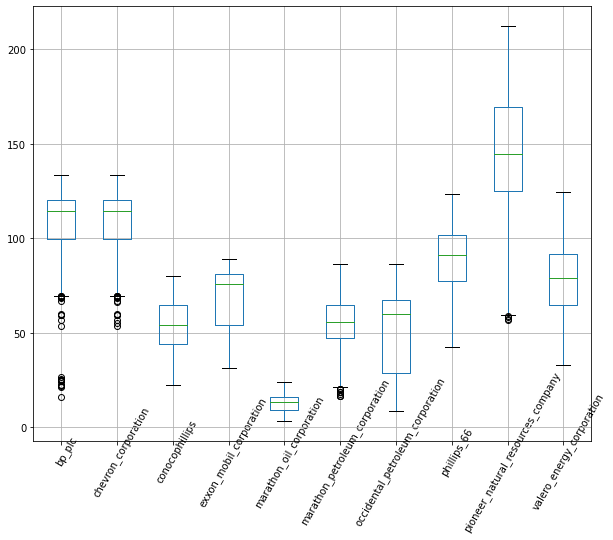

In [490]:
#dt.hist();
fig, axs = plt.subplots(nrows = 1,
                        ncols = 1,
                        figsize = (10, 8));
dt.boxplot()
plt.setp( axs.get_xticklabels(), rotation = 60, rotation_mode='anchor', ha='center');
dt.isnull().sum()

In [491]:
%whos DataFrame

Variable           Type         Data/Info
-----------------------------------------
X_train            DataFrame                const  lag_ph<...>n\n[194 rows x 2 columns]
X_valid            DataFrame                const  lag_ph<...>5    1.0            87.25
a                  DataFrame                Index_d_f_pip<...>\n[1479 rows x 1 columns]
data               DataFrame                i_g_airline  <...>\n[7742 rows x 2 columns]
data_target        DataFrame                valero_energy<...>\n[1014 rows x 1 columns]
dataframe          DataFrame                d_f_pipeline <...>\n[1479 rows x 9 columns]
dataframe_target   DataFrame                bp_plc  chevr<...>n[1479 rows x 10 columns]
delta_df           DataFrame              date day_of_wee<...>n\n[243 rows x 3 columns]
df                 DataFrame                Index  Count\<...>n\n[383 rows x 2 columns]
df_0               DataFrame                Index  Count <...>n[1479 rows x 24 columns]
df_1               DataFrame        

In [496]:
for col in dt.columns:
    dt[f'{col}_lagg'] = dt[f'{col}'].shift(1)
dt

,bp_plc,chevron_corporation,conocophillips,exxon_mobil_corporation,marathon_oil_corporation,marathon_petroleum_corporation,occidental_petroleum_corporation,phillips_66,pioneer_natural_resources_company,valero_energy_corporation,...,bp_plc_lagg_lagg,chevron_corporation_lagg_lagg,conocophillips_lagg_lagg,exxon_mobil_corporation_lagg_lagg,marathon_oil_corporation_lagg_lagg,marathon_petroleum_corporation_lagg_lagg,occidental_petroleum_corporation_lagg_lagg,phillips_66_lagg_lagg,pioneer_natural_resources_company_lagg_lagg,valero_energy_corporation_lagg_lagg
2017-03-01,113.88,113.88,49.05,83.02,16.45,50.99,66.24,79.37,193.52,68.48,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-03-02,113.36,113.36,48.21,83.30,16.14,51.04,65.50,78.33,191.17,66.45,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-03-03,113.55,113.55,47.82,82.46,16.18,51.27,64.86,78.34,194.18,66.08,...,113.88,113.88,49.05,83.02,16.45,50.99,66.24,79.37,193.52,68.48
2017-03-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,113.36,113.36,48.21,83.30,16.14,51.04,65.50,78.33,191.17,66.45
2017-03-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,113.55,113.55,47.82,82.46,16.18,51.27,64.86,78.34,194.18,66.08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,111.19,111.19,59.83,61.31,12.51,58.00,30.98,87.73,164.58,82.48
2021-03-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,111.56,111.56,59.19,61.97,12.20,57.75,30.63,88.66,165.63,82.42
2021-03-15,110.25,110.25,58.16,60.39,12.05,57.86,29.30,87.84,165.76,81.83,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-03-16,107.64,107.64,56.58,59.11,11.46,56.21,28.17,84.93,163.03,79.32,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [500]:
#dt.to_csv('../EDA-Brandon/closing10_holiweekend_nans.csv')
dataframe.head(10)

,d_f_pipeline,d_g_oil,i_g_airline,d_f_pipeline_imputed,d_g_oil_imputed,i_g_airline_imputed,d_f_pipeline_roll5d,d_g_oil_roll5d,i_g_airline_roll5d,d_f_pipeline_imputed_lagg,d_g_oil_imputed_lagg,i_g_airline_imputed_lagg,d_f_pipeline_roll5d_lagg,d_g_oil_roll5d_lagg,i_g_airline_roll5d_lagg
2017-03-01,-0.3,-0.209091,-0.500000,-0.3,-0.209091,-0.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-03-02,NaN,-0.133333,-0.033333,0.0,-0.133333,-0.033333,NaN,NaN,NaN,-0.3,-0.209091,-0.500000,NaN,NaN,NaN
2017-03-03,0.0,0.075000,-0.220000,0.0,0.075000,-0.220000,NaN,NaN,NaN,0.0,-0.133333,-0.033333,NaN,NaN,NaN
2017-03-04,-0.3,-0.066667,-0.200000,-0.3,-0.066667,-0.200000,NaN,NaN,NaN,0.0,0.075000,-0.220000,NaN,NaN,NaN
2017-03-05,NaN,-0.350000,-0.250000,0.0,-0.350000,-0.250000,-0.12,-0.136818,-0.240667,-0.3,-0.066667,-0.200000,NaN,NaN,NaN
2017-03-06,-0.3,0.050000,-0.240000,-0.3,0.050000,-0.240000,-0.12,-0.085000,-0.188667,0.0,-0.350000,-0.250000,-0.12,-0.136818,-0.240667
2017-03-07,-0.3,-0.333333,-0.300000,-0.3,-0.333333,-0.300000,-0.18,-0.125000,-0.242000,-0.3,0.050000,-0.240000,-0.12,-0.085000,-0.188667
2017-03-08,NaN,-0.216667,-0.066667,0.0,-0.216667,-0.066667,-0.18,-0.183333,-0.211333,-0.3,-0.333333,-0.300000,-0.18,-0.125000,-0.242000
2017-03-09,NaN,-0.300000,-0.457143,0.0,-0.300000,-0.457143,-0.12,-0.230000,-0.262762,0.0,-0.216667,-0.066667,-0.18,-0.183333,-0.211333
2017-03-10,-0.6,-0.150000,-0.140000,-0.6,-0.150000,-0.140000,-0.24,-0.190000,-0.240762,0.0,-0.300000,-0.457143,-0.12,-0.230000,-0.262762


In [497]:
for col in dataframe[['d_f_pipeline_imputed', 'd_g_oil_imputed', 'i_g_airline_imputed', 'd_f_pipeline_roll5d', 'd_g_oil_roll5d', 'i_g_airline_roll5d']].columns:
    dataframe[f'{col}_lagg'] = dataframe[f'{col}'].shift(1)
dataframe

,d_f_pipeline,d_g_oil,i_g_airline,d_f_pipeline_imputed,d_g_oil_imputed,i_g_airline_imputed,d_f_pipeline_roll5d,d_g_oil_roll5d,i_g_airline_roll5d,d_f_pipeline_imputed_lagg,d_g_oil_imputed_lagg,i_g_airline_imputed_lagg,d_f_pipeline_roll5d_lagg,d_g_oil_roll5d_lagg,i_g_airline_roll5d_lagg
2017-03-01,-0.300000,-0.209091,-0.500000,-0.300000,-0.209091,-0.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-03-02,NaN,-0.133333,-0.033333,0.000000,-0.133333,-0.033333,NaN,NaN,NaN,-0.300000,-0.209091,-0.500000,NaN,NaN,NaN
2017-03-03,0.000000,0.075000,-0.220000,0.000000,0.075000,-0.220000,NaN,NaN,NaN,0.000000,-0.133333,-0.033333,NaN,NaN,NaN
2017-03-04,-0.300000,-0.066667,-0.200000,-0.300000,-0.066667,-0.200000,NaN,NaN,NaN,0.000000,0.075000,-0.220000,NaN,NaN,NaN
2017-03-05,NaN,-0.350000,-0.250000,0.000000,-0.350000,-0.250000,-1.200000e-01,-0.136818,-0.240667,-0.300000,-0.066667,-0.200000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-14,-0.066667,-0.051613,-0.372727,-0.066667,-0.051613,-0.372727,-3.000000e-02,-0.190912,-0.251588,0.166667,-0.258824,-0.226667,3.333333e-02,-0.232401,-0.209843
2021-03-15,NaN,-0.147826,-0.126316,0.000000,-0.147826,-0.126316,-1.291434e-09,-0.168898,-0.224928,-0.066667,-0.051613,-0.372727,-3.000000e-02,-0.190912,-0.251588
2021-03-16,-0.433333,-0.228788,-0.231250,-0.433333,-0.228788,-0.231250,-8.666667e-02,-0.164343,-0.233451,0.000000,-0.147826,-0.126316,-1.291434e-09,-0.168898,-0.224928
2021-03-17,-0.100000,-0.197143,-0.224242,-0.100000,-0.197143,-0.224242,-8.666667e-02,-0.176839,-0.236240,-0.433333,-0.228788,-0.231250,-8.666667e-02,-0.164343,-0.233451


In [503]:
#dataframe.to_csv('../EDA-Brandon/top3_sentiment_imputed0_rolled5d.csv')

In [502]:
dataframe

,d_f_pipeline,d_g_oil,i_g_airline,d_f_pipeline_imputed,d_g_oil_imputed,i_g_airline_imputed,d_f_pipeline_roll5d,d_g_oil_roll5d,i_g_airline_roll5d,d_f_pipeline_imputed_lagg,d_g_oil_imputed_lagg,i_g_airline_imputed_lagg,d_f_pipeline_roll5d_lagg,d_g_oil_roll5d_lagg,i_g_airline_roll5d_lagg
2017-03-01,-0.300000,-0.209091,-0.500000,-0.300000,-0.209091,-0.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-03-02,NaN,-0.133333,-0.033333,0.000000,-0.133333,-0.033333,NaN,NaN,NaN,-0.300000,-0.209091,-0.500000,NaN,NaN,NaN
2017-03-03,0.000000,0.075000,-0.220000,0.000000,0.075000,-0.220000,NaN,NaN,NaN,0.000000,-0.133333,-0.033333,NaN,NaN,NaN
2017-03-04,-0.300000,-0.066667,-0.200000,-0.300000,-0.066667,-0.200000,NaN,NaN,NaN,0.000000,0.075000,-0.220000,NaN,NaN,NaN
2017-03-05,NaN,-0.350000,-0.250000,0.000000,-0.350000,-0.250000,-1.200000e-01,-0.136818,-0.240667,-0.300000,-0.066667,-0.200000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-14,-0.066667,-0.051613,-0.372727,-0.066667,-0.051613,-0.372727,-3.000000e-02,-0.190912,-0.251588,0.166667,-0.258824,-0.226667,3.333333e-02,-0.232401,-0.209843
2021-03-15,NaN,-0.147826,-0.126316,0.000000,-0.147826,-0.126316,-1.291434e-09,-0.168898,-0.224928,-0.066667,-0.051613,-0.372727,-3.000000e-02,-0.190912,-0.251588
2021-03-16,-0.433333,-0.228788,-0.231250,-0.433333,-0.228788,-0.231250,-8.666667e-02,-0.164343,-0.233451,0.000000,-0.147826,-0.126316,-1.291434e-09,-0.168898,-0.224928
2021-03-17,-0.100000,-0.197143,-0.224242,-0.100000,-0.197143,-0.224242,-8.666667e-02,-0.176839,-0.236240,-0.433333,-0.228788,-0.231250,-8.666667e-02,-0.164343,-0.233451


> *Observation*:
> Pioneer Natural Resources, a company well integrated in all three phases of the oil & gas product flow, has a large spread in closing stock price, on the other hand, Marathon Oil(MRO) stock is over 4x cheaper and much less volatile.

In [279]:
# MODEL FINISHED!
# Our model that minimizes AIC on the training data is the ARIMA(0,1,0).
# This model has an AIC of 951.67

# Instantiate best model found by GridSearch above
model = ARIMA(#endog = np.array(y_train),  # endog = endogenous "Target" Variable
              endog = y_train.astype(float).dropna(),
              #dates = y_train.index, # pass in training index using the ARIMA dates parameter
              #freq = 'B',
              order = (0,1,0))

# Fit ARIMA model.
arima = model.fit()
# Generate predictions based on valid set.
start_valid = y_valid.index[0]
end_valid = y_valid.index[-1]
#print(start_valid, type(start_valid))
#print(end_valid, type(end_valid))
preds = model.predict(params = arima.params,
                      start = start_valid,
                      end = end_valid)

# Plot data.
plt.figure(figsize=(10,6))

# Plot training data.
#plt.plot(y_train.index, pd.DataFrame(y_train), color = 'blue')
plt.plot(y_train.index, pd.DataFrame(y_train).diff(), color = 'blue')
# Plot validing data.
#plt.plot(y_valid.index, pd.DataFrame(y_valid), color = 'orange')
plt.plot(y_valid.index, pd.DataFrame(y_valid).diff(), color = 'orange')
# Plot predicted valid values.
plt.plot(y_valid.index, preds, color = 'green')

plt.title(label = 'Once-Differenced Global Mean Temperature with ARIMA(3, 1, 3) Predictions', fontsize=16)

KeyError: 'only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices'

NOTES
https://stackoverflow.com/questions/56007991/predict-time-series-with-statsmodels-var-and-encountering-valueerror
LSSN 10.02 & 10.03 GA

In [ ]:
fig, ax = plt.subplots(nrows = 3,
                       ncols = 1,
                       figsize=(20,10), 
                       sharex = True)

df_sub = df[['workplaces']]

# Element-wise subtraction w/ a Series, for set_title("RSS")
df_diff = df_differenced.workplaces

fsize = 15
p = 5; d = 1; q = 1

for nax in range(3):
    if nax == 0:
        # Instantiate the AR Model, choose "p" (p, d = 1, q = 0)
        model = ARIMA(df_sub, order=(p,d,0))
        # Fit the AR Model
        preds_AR = model.fit(disp=-1)
        ax[nax].plot(preds_AR.fittedvalues, label = f'AR({p}) Predictions')
        # Residual Sum of Squares
        ax[nax].set_title(f'AR({p}) Model - RSS: %.4f'%sum((preds_AR.fittedvalues - df_diff)**2),
                          fontsize = fsize)
        
    elif nax == 1:
        # MA Model, choose "q" (p = 0, d = 1, q)
        model = ARIMA(df_sub, order=(0,d,q))
        preds_MA = model.fit(disp=-1)
        ax[nax].plot(preds_MA.fittedvalues, label = f'MA({q}) Predictions')
        # Residual Sum of Squares
        ax[nax].set_title(f'MA({q}) Model - RSS: %.4f'%sum((preds_MA.fittedvalues - df_diff)**2),
                          fontsize = fsize)
        
    elif nax == 2:
        # ARIMA model, choose "p" & "q" (p, d, q)
        model = ARIMA(df_sub, order=(p,d,q))
        preds_ARIMA = model.fit(disp=-1)
        ax[nax].plot(preds_ARIMA.fittedvalues, label = f'ARIMA({p},{d},{q}) Predictions')
        # Residual Sum of Squares
        ax[nax].set_title(f'ARIMA({p},{d},{q}) Model - RSS: %.4f'%sum((preds_ARIMA.fittedvalues - df_diff)**2),
                          fontsize = fsize)
        
    ax[nax].plot(df_diff, label = 'Original')    
    ax[nax].legend()
    #ax[nax].set_xlabel('Timestamp')
    ax[nax].set_ylabel('Mobility (% Change)', fontsize = fsize)
    
plt.tight_layout()